**Sub-Nyquist Sampling and Recovery of Pulse Streams with the Real Parts of Fourier Coefficients**
<br>
Team Members:


1.   Adithi Sadananda Upadhya, 191EC101
2.   V Kartikeya, 191EC256



In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.signal import butter, lfilter, freqz

A. PROBLEM FORMULATION

FRI Signals can be modelled as <br>
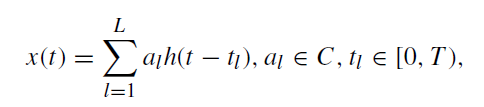
<br> where h(t) is the known pulse shape with a short duration
in time domain.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


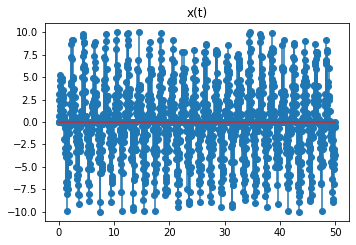

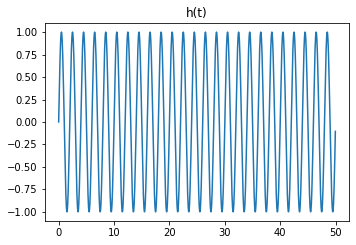

In [83]:
# h(t) is a sine signal, amplitude parameters a_sub{l} are randomly selected, x(t) is modelled as a stream of diracs
plt.rcParams["figure.figsize"] = (12, 8)
x_t = []
T = 50.0 # in seconds
fs = 30.0
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)
h_t = np.sin(np.pi*t)
for i in range(len(h_t)):
  p = random.randint(0,10)
  x_t.append(p*h_t[i])
plt.subplot(2,2,1)
plt.stem(t,x_t)
plt.title("x(t)")
plt.show()

plt.subplot(2,2,2)
plt.plot(t,h_t)
plt.title("h(t)")
plt.show()


The only unknown parameters
are time delays and amplitudes 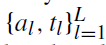


Since x(t) has 2L degrees of freedom within any length-T
time interval, Dragotti et al. (P. L. Dragotti, M. Vetterli, and T. Blu,  *Sampling moments and reconstructing
signals of finite rate of innovation: Shannon meets strang-
fix*, IEEE Trans. Signal Process., vol. 55, no. 5, pp. 1741-1757,
May 2007) shows that at least 2L samples
(Fourier coefficients) per time T are required in order to
recover the signal x(t).

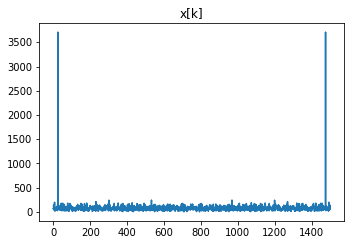

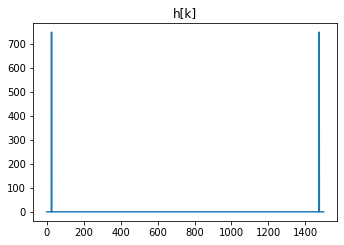

In [84]:
plt.rcParams["figure.figsize"] = (12, 8)
X = np.fft.fft(x_t);
H = np.fft.fft(h_t);
plt.subplot(2,2,1)
plt.plot(abs(X));
plt.title('x[k]')
plt.show()

plt.subplot(2,2,2)
plt.plot(abs(H));
plt.title('h[k]')
plt.show()

Because the transmit pulse h(t) and its Fourier transform
H(k) are known, the amplitude and time delay parameters can be solved
by acquiring a set of nonzero Fourier coeffcients X(kw0),
where H(kw0)!=0. Many algorithms for solving this exist,
among which are annihilating filter and matrix pencil. <br> <br>
B. FREQUENCY SELECTION AND SPECTRUM
ALIASING PROBLEM <br>
For the acquisition of an arbitrary set of Fourier coeffcients, the authors
have proposed a modulating and LPF based sampling scheme, in which 
the original continuous-time signal x(t) is modulated and
then filtered before being (uniformly) sampled with sampling
period Ts.


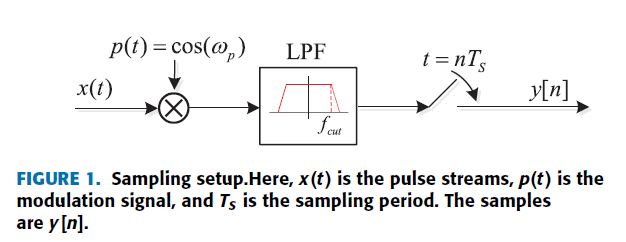

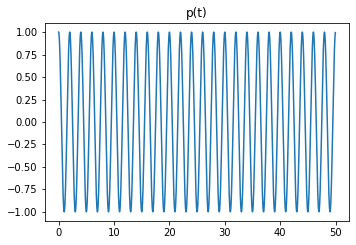

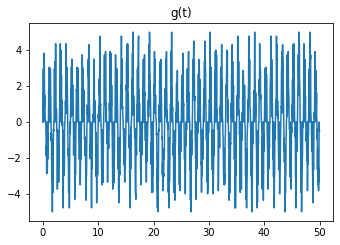

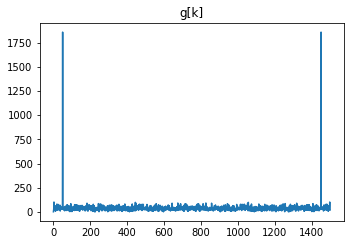

In [85]:
# 1. The pulse streams x(t) is modulated with a cosine signal p(t), to obtain signal g(t)
plt.rcParams["figure.figsize"] = (12, 8)
p_t = np.cos(np.pi*t)
plt.subplot(2,2,1)
plt.plot(t,p_t)
plt.title("p(t)")
plt.show()

g_t = x_t * p_t
plt.subplot(2,2,2)
plt.plot(t,g_t)
plt.title("g(t)")
plt.show()

G = np.fft.fft(g_t);
plt.subplot(2,2,3)
plt.plot(abs(G));
plt.title('g[k]')
plt.show()

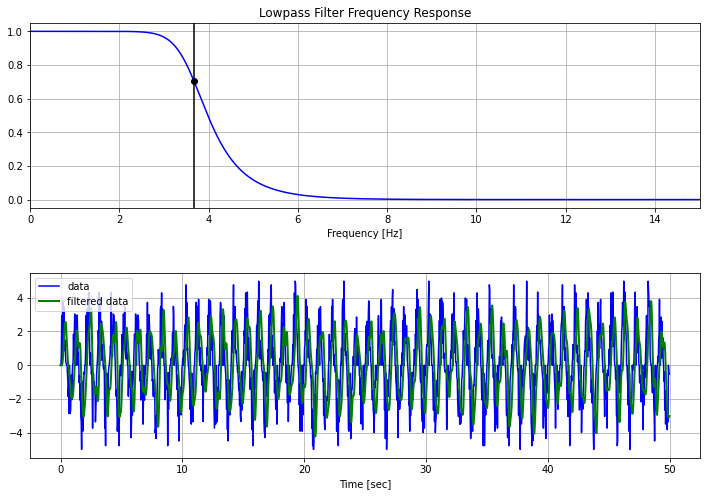

In [86]:
# 2. modulated signal g(t) is filtered with a LPF, followed by sampling at twice its cut-off frequency with an analog-digital converter (ADC)
# LPF - second order butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Setting filter requirements
order = 6
fs = 30.0       
cutoff = 3.667 

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filtering and plotting
y = butter_lowpass_filter(g_t, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, g_t, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

C. 
Two modulation processes from different channels are used to
solve the spectrum aliasing problem, which allows to extract
the real parts of an arbitrary band of Fourier coeffcients from
the aliased spectrum.

In [87]:
p1_t = np.cos(np.pi*t)
p2_t = np.cos(1.005 * np.pi*t) # (w + delta_w)*t                                    0 < delta_w = 0.005*p1< w_cut = 3.667 
# The signal x(t) is splited into two channels and modulated with cosine signals p1(t) and p2(t)
g1_t = x_t * p1_t
g2_t = x_t * p2_t

In [88]:
M = int(cutoff/(0.005*np.pi)) # M = [wcut/delta_w]
print(M)

233


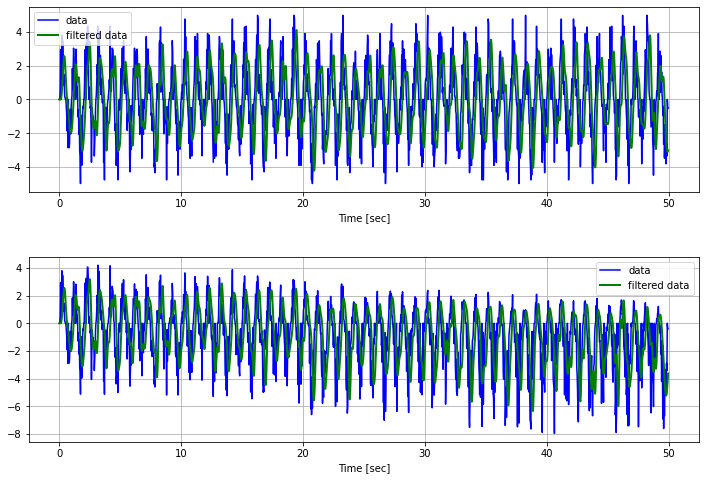

In [89]:
# modulated signal in each channel is then filtered with a LPF
y1_t = butter_lowpass_filter(g1_t, cutoff, fs, order)
plt.subplot(2, 1, 1)
plt.plot(t, g1_t, 'b-', label='data')
plt.plot(t, y1_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y2_t = butter_lowpass_filter(g2_t, cutoff, fs, order)
plt.subplot(2, 1, 2)
plt.plot(t, g2_t, 'b-', label='data')
plt.plot(t, y2_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

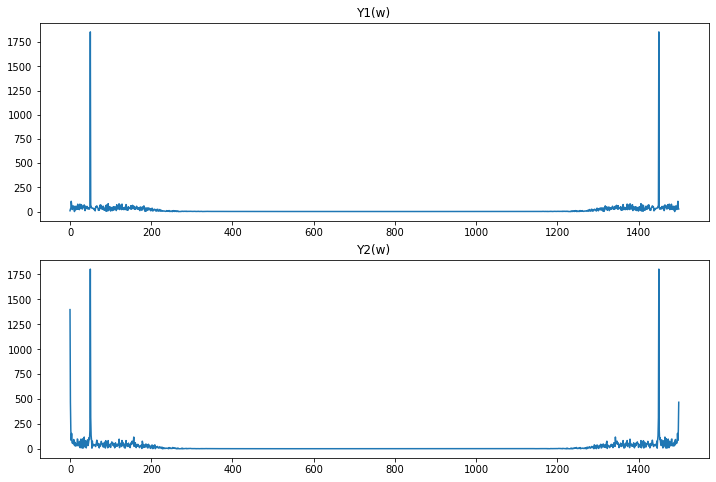

In [90]:
Y1 = np.fft.fft(y1_t)
plt.subplot(2,1,1)
plt.plot(abs(Y1));
plt.title('Y1(w)')

Y2 = np.fft.fft(y2_t)
plt.subplot(2,1,2)
plt.plot(abs(Y2));
plt.title('Y2(w)')

plt.show()

In [91]:
# obtain 2M+ 2 real parts of fourier coefficients 
Y_w = Y1 + Y2 
U = []
for i in range(2*M + 2):
  U.append(Y_w[i].real)
print(len(U))

468


In [92]:
print(U) #measurements

[-1387.9365835535045, 57.16402995276114, -7.773230874795232, 115.01726181240068, -88.36591848942328, 30.563710072144225, 1.8794959360907733, -83.01679756132748, 64.47375612627565, -113.46916328446395, -21.090215975795097, 14.842205567119908, -64.23029065033613, 46.514502078006096, -50.89038667923097, -62.95582206537458, -2.3374662784761355, 33.29024876955883, -2.3298888655147696, -120.91178726955374, 66.33348353041367, -9.423507322918915, 55.969336599935026, -48.07231490147468, 17.686988674071124, -17.249083721751248, -120.59374528157015, -62.39131884963709, 131.04430434025554, 75.15274155406999, 30.503511013181388, -112.7747564858786, -150.4713186530101, 20.53697140912723, -3.1762741569271533, -87.47575811158869, 28.77572515403442, 11.6072703312887, 61.73028676224015, 52.46929702752753, 42.5492570919594, -76.84434641143008, 98.17382940973803, -62.290930354905164, -5.983426218782013, 27.339634673266083, 5.54749313647639, -46.4445850606807, -72.40884013579142, -168.348089507257, -2623.7

MULTI CHANNEL SYSTEM

This two channel system can be further extended to create a multi-channel sampling system - <br>
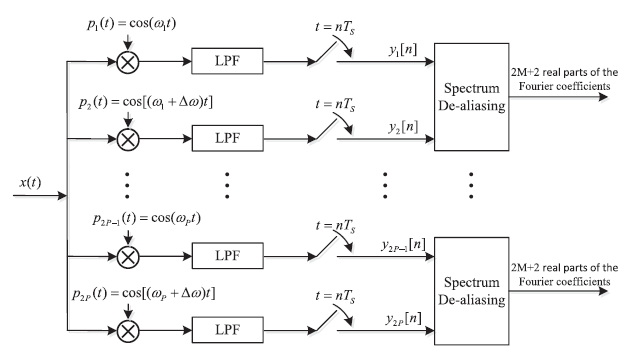

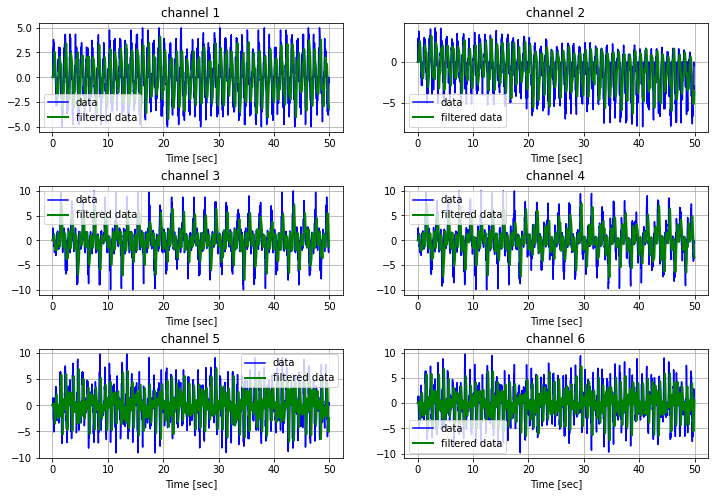

In [93]:
P = 3
p1_t = np.cos(np.pi*t)
p2_t = np.cos(1.005 * np.pi*t) # (w + delta_w)*t                                   0 < delta_w = 0.005*p1< w_cut = 3.667 

p3_t = np.cos(2*np.pi*t) 
p4_t = np.cos(2.005*np.pi*t)

p5_t = np.cos(3.5*np.pi*t)
p6_t = np.cos(3.505*np.pi*t)

# The signal x(t) is splited into 2P channels and modulated with the cosine signals
g1_t = x_t * p1_t
g2_t = x_t * p2_t
g3_t = x_t * p3_t
g4_t = x_t * p4_t
g5_t = x_t * p5_t
g6_t = x_t * p6_t

# modulated signal in each channel is then filtered with a LPF
y1_t = butter_lowpass_filter(g1_t, cutoff, fs, order)
plt.subplot(3, 2, 1)
plt.title("channel 1")
plt.plot(t, g1_t, 'b-', label='data')
plt.plot(t, y1_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y2_t = butter_lowpass_filter(g2_t, cutoff, fs, order)
plt.subplot(3, 2, 2)
plt.title("channel 2")
plt.plot(t, g2_t, 'b-', label='data')
plt.plot(t, y2_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y3_t = butter_lowpass_filter(g3_t, cutoff, fs, order)
plt.subplot(3, 2, 3)
plt.title("channel 3")
plt.plot(t, g3_t, 'b-', label='data')
plt.plot(t, y3_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y4_t = butter_lowpass_filter(g4_t, cutoff, fs, order)
plt.subplot(3, 2, 4)
plt.title("channel 4")
plt.plot(t, g4_t, 'b-', label='data')
plt.plot(t, y4_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y5_t = butter_lowpass_filter(g5_t, cutoff, fs, order)
plt.subplot(3, 2, 5)
plt.title("channel 5")
plt.plot(t, g5_t, 'b-', label='data')
plt.plot(t, y5_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

y6_t = butter_lowpass_filter(g6_t, cutoff, fs, order)
plt.subplot(3, 2, 6)
plt.title("channel 6")
plt.plot(t, g6_t, 'b-', label='data')
plt.plot(t, y6_t, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.show()

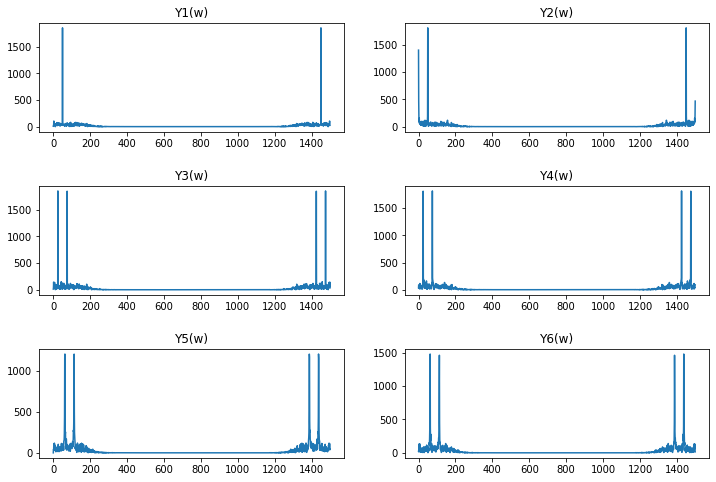

In [94]:
Y1 = np.fft.fft(y1_t)
plt.subplot(3,2,1)
plt.plot(abs(Y1));
plt.title('Y1(w)')

Y2 = np.fft.fft(y2_t)
plt.subplot(3,2,2)
plt.plot(abs(Y2));
plt.title('Y2(w)')

Y3 = np.fft.fft(y3_t)
plt.subplot(3,2,3)
plt.plot(abs(Y3));
plt.title('Y3(w)')

Y4 = np.fft.fft(y4_t)
plt.subplot(3,2,4)
plt.plot(abs(Y4));
plt.title('Y4(w)')

Y5 = np.fft.fft(y5_t)
plt.subplot(3,2,5)
plt.plot(abs(Y5));
plt.title('Y5(w)')

Y6 = np.fft.fft(y6_t)
plt.subplot(3,2,6)
plt.plot(abs(Y6));
plt.title('Y6(w)')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [95]:
# obtain 2M+ 2 real parts of fourier coefficients 
Y_w = Y1 + Y2 + Y3 +  Y4 + Y5
U_w = []
for i in range(2*M + 2):
  U_w.append(Y_w[i].real)
print(len(U_w))

468


RECOVERY 

Recovery from sparse based signal + Orthogonal Matching Pursuit algorithm to solve the L0 norm

In [96]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

In [97]:
# modelling the sparse signal without noise 
n_components, n_features = 468, 100 # M=468
n_nonzero_coefs = 250
U, phi, s = make_sparse_coded_signal( #creating a sparse matrix
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
) # U = phi . s
# Generate a signal as a sparse combination of dictionary elements.
# Return a matrix Y = DX, such as D is (n_features, n_components), X is (n_components, n_samples) and each column of X has exactly n_nonzero_coefs non-zero elements.
(sol,) = s.nonzero()

In [98]:
# with additive noise
U_noisy = U + 0.05 * np.random.randn(len(U))

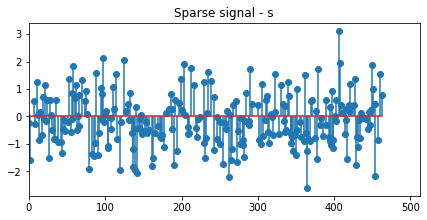

In [99]:
# sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal - s")
plt.stem(sol, s[sol], use_line_collection=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  X, y[:, k], n_nonzero_coefs, tol, copy_X=copy_X, return_path=return_path


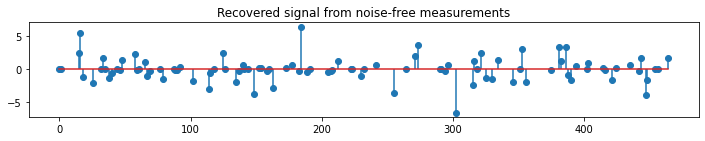

In [100]:
# reconstruction using OMP 
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs, normalize=False)
omp.fit(phi, U)
coef = omp.coef_
(sol_r,) = coef.nonzero()
plt.subplot(4, 1, 1)
#plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(sol_r, coef[sol_r], use_line_collection=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  X, y[:, k], n_nonzero_coefs, tol, copy_X=copy_X, return_path=return_path


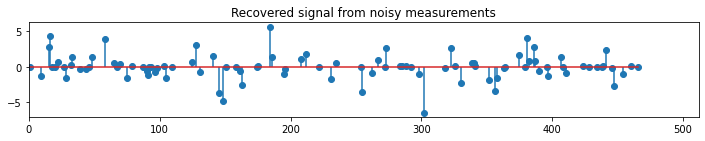

In [101]:
# reconstruction in presence of noise
omp.fit(phi, U_noisy)
coef = omp.coef_
(sol_r,) = coef.nonzero()
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(sol_r, coef[sol_r], use_line_collection=True)
plt.show()